In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
from astropy.wcs import WCS
import astropy.coordinates as coord
import astropy.units as u
from matplotlib.patches import Circle
from pyutils import *
import astropy.io.fits as fits
import healpy as hp
from astropy.table import Table,join
from dataloc import *
import types

%load_ext autoreload
%autoreload 2

In [2]:
def get_app_mag(flux):
    """This converts nanomaggies into Pogson magnitudes"""
    return 22.5 - 2.5*np.log10(flux)

# This corresponds to 8.33 square degrees and empircally makes sense by looking at the randoms
TILE_RADIUS = 5862.0 * u.arcsec # arcsec

def find_tiles_for_galaxies(tiles_df, gals_df, num_tiles_to_find):
    num_galaxies = len(gals_df.RA)
    num_tiles = len(tiles_df.RA)

    tiles_coord = coord.SkyCoord(ra=tiles_df.RA.to_numpy()*u.degree, dec=tiles_df.Dec.to_numpy()*u.degree, frame='icrs')
    gals_coord = coord.SkyCoord(ra=gals_df.RA.to_numpy()*u.degree, dec=gals_df.Dec.to_numpy()*u.degree, frame='icrs')

    # Structure for resultant data
    nearest_tile_ids = np.zeros((num_galaxies, num_tiles_to_find), dtype=int)
    ntiles_inside = np.zeros((num_galaxies), dtype=int)

    for n in range(num_tiles_to_find):
        idx, d2d, d3d = coord.match_coordinates_sky(gals_coord, tiles_coord, nthneighbor=n+1, storekdtree='kdtree_tiles')
        nearest_tile_ids[:,n] = tiles_df.iloc[idx].TILEID
        ntiles_inside += (d2d < TILE_RADIUS).astype(int)

    
    return ntiles_inside, nearest_tile_ids

def read_merged_BGS_file():
    table = Table.read(IAN_BGS_MERGED_FILE, format='fits')

    # TODO why isn't the endian thing a problem anymore?
    obj_type = table['SPECTYPE'].data.data
    dec = table['DEC']#.astype("<f8") # Big endian vs little endian regression in pandas. Convert more of these fields like this
    ra = table['RA']#.astype("<f8") # as needed if using pandas with this data
    z_obs = table['Z'].data.data
    target_id = table['TARGETID']
    #flux_r = table['FLUX_R']
    #flux_g = table['FLUX_G']
    app_mag_r = get_app_mag(table['FLUX_R'])
    app_mag_g = get_app_mag(table['FLUX_G'])
    g_r_apparent = app_mag_g - app_mag_r
    sdss_g_r = table['ABSMAG_SDSS_G'] - table['ABSMAG_SDSS_R'] 
    G_R_JM1 = table['ABSMAG01_SDSS_G'] - table['ABSMAG01_SDSS_R']
    p_obs = table['PROB_OBS'] 
    unobserved = table['Z'].mask
    deltachi2 = table['DELTACHI2'].data.data
    ntiles = table['NTILE']
    abs_mag_sdss = table['ABSMAG_SDSS_R']
    dn4000 = table['DN4000'].data.data

    df = pd.DataFrame({
        'SPECTYPE': obj_type,
        'Dec': dec,
        'RA': ra,
        'z': z_obs,
        'TARGETID': target_id,
        #'FLUX_R': flux_r,
        #'FLUX_G': flux_g,
        'APP_MAG_R': app_mag_r,
        'APP_MAG_G': app_mag_g,
        'G_R_APPARENT': g_r_apparent,
        'SDSS_G_R': sdss_g_r,
        'G_R_JM1': G_R_JM1,
        'PROB_OBS': p_obs,
        'UNOBSERVED': unobserved,
        'DELTACHI2': deltachi2,
        'NTILE': ntiles,
        'ABS_MAG_SDSS': abs_mag_sdss,
        'DN4000': dn4000
        })

    return df

def read_tiles_file():
    tiles_table = Table.read(BGS_Y3_TILES_FILE, format='csv')
    tiles_table.keep_columns(['TILEID', 'FAFLAVOR', 'TILERA', 'TILEDEC'])
    tiles_df = pd.DataFrame({'RA': tiles_table['TILERA'].astype("<f8"), 'Dec': tiles_table['TILEDEC'].astype("<f8"), 'FAFLAVOR': tiles_table['FAFLAVOR'], 'TILEID': tiles_table['TILEID']})
    tiles_BGS = tiles_df[tiles_df.FAFLAVOR == 'mainbright']
    tiles_BGS.reset_index(drop=True, inplace=True)
    return tiles_BGS

# Create a merged master BGS data file

In [ ]:
hdul = fits.open(BGS_FASTSPEC_FILE, memmap=True)
#print(hdul[1].columns)
data = hdul[1].data
fastspecfit_id = data['TARGETID']
DN4000 = data['DN4000'] # TODO there is also DN4000_OBS and DN4000_MODEL (and inverse variance)
FSF_G = data['ABSMAG01_SDSS_G']
FSF_R = data['ABSMAG01_SDSS_R']
hdul.close()

print(len(fastspecfit_id))
print(len(DN4000))

fastspecfit_table = Table([fastspecfit_id, DN4000, FSF_G, FSF_R], names=('TARGETID', 'DN4000', 'ABSMAG01_SDSS_G', 'ABSMAG01_SDSS_R'))


In [ ]:
# Main file
main_table = Table.read(BGS_ANY_FULL_FILE, format='fits')
print(len(main_table))

In [ ]:
# Prob obs file
p_table = Table.read(BGS_PROB_OBS_FILE, format='fits')
print(len(p_table))

# Join them all on TARGETID
joined_table = join(main_table, p_table, keys="TARGETID")
print(len(joined_table))


In [ ]:
# The lost galaxies will not have fastspecfit rows I think
final_table = join(joined_table, fastspecfit_table, join_type='left', keys="TARGETID")
print(len(final_table))

In [ ]:
# Sanity check that everything went as intended
assert len(final_table) == len(main_table)

In [ ]:
final_table['TILES'][0]

In [ ]:
# Filter to needed columns only and save
final_table.keep_columns(['TARGETID', 'SPECTYPE', 'DEC', 'RA', 'Z', 'FLUX_R', 'FLUX_G', 'BITWEIGHTS', 'PROB_OBS', 'ZWARN', 'DELTACHI2', 'NTILE', 'TILES', 'ABSMAG_SDSS_R', 'ABSMAG_SDSS_G', 'DN4000', 'ABSMAG01_SDSS_G', 'ABSMAG01_SDSS_R'])
final_table.rename_column('Z_not4clus', 'Z')
final_table.write(IAN_BGS_MERGED_FILE, format='fits', overwrite='True')

In [ ]:
del(main_table)
del(p_table)
del(fastspecfit_table)
del(final_table)

# Augment with my version of NTILE

In [ ]:
tiles_BGS = read_tiles_file()
galaxies_df = read_merged_BGS_file()

In [ ]:
ntiles_inside, nearest_tile_ids = find_tiles_for_galaxies(tiles_BGS, galaxies_df, 10)


In [ ]:
table = Table.read(IAN_BGS_MERGED_FILE, format='fits')
table.add_column(ntiles_inside, name="NTILE_MINE")
table.add_column(nearest_tile_ids, name="NEAREST_TILEIDS")

In [ ]:
table.write(IAN_BGS_MERGED_FILE, format='fits', overwrite='True')

In [ ]:
del(table)
del(tiles_BGS)
del(galaxies_df)

# Jura Quick Analysis

In [ ]:
# Don't have all files needed to use the above pipline yet, so just working with what we have

# Main file
main_table = Table.read(BGS_Y3_ANY_FULL_FILE, format='fits')
print(len(main_table))

# Filter to needed columns only and save
main_table.keep_columns(['TARGETID', 'SPECTYPE', 'DEC', 'RA', 'Z', 'FLUX_R', 'FLUX_G', 'ZWARN', 'DELTACHI2', 'NTILE', 'TILES'])

galaxies_df = pd.DataFrame({
    'Dec': main_table['DEC'],
    'RA': main_table['RA'],
    })

tiles_BGS = read_tiles_file()

ntiles_inside, nearest_tile_ids = find_tiles_for_galaxies(tiles_BGS, galaxies_df, 10)

main_table.add_column(ntiles_inside, name="NTILE_MINE")
main_table.add_column(nearest_tile_ids, name="NEAREST_TILEIDS")

main_table.write(IAN_BGS_Y3_MERGED_FILE, format='fits', overwrite='True')

del(main_table)
del(tiles_BGS)
del(galaxies_df)

# Examine data in Merged BGS File

In [3]:
# Pick one
#table = Table.read(IAN_BGS_MERGED_FILE, format='fits')
table = Table.read(IAN_BGS_Y3_MERGED_FILE, format='fits')

In [7]:
tiles_BGS = read_tiles_file()

In [4]:
# See two equivalent ways of determining which rows are for unobserved galaxies
one=table['ZWARN'] == 999999
two=table['Z'].mask
assert(np.all(one == two))


In [ ]:
plt.hist(table['Z'], bins=50)
plt.title("Z")
plt.yscale('log')
print(np.min(table['Z']), np.max(table['Z']))
print(table['Z'].mask)

In [ ]:
print(np.unique(table['ZWARN']))
#print(np.unique(table['ZWARN_MTL']))
print(np.unique(table['SPECTYPE']))
print(np.unique(table['NTILE']))
#print(np.unique(table['TARGET_STATE']))

In [ ]:
tileids[0]

## Cut to the galaxy data we actually need

In [20]:
# TODO this gets easilly out of sync with the .py file that does the 'production' filtering

APP_MAG_CUT = 19.5
Z_MIN = 0.01
Z_MAX = 0.8
obj_type = table['SPECTYPE'].data.data
dec = table['DEC'].astype("<f8") # Big endian vs little endian regression in pandas. Convert more of these fields like this
ra = table['RA'].astype("<f8") # as needed if using pandas with this data
z_obs = table['Z'].data.data
target_id = table['TARGETID']
flux_r = table['FLUX_R']
flux_g = table['FLUX_G']
app_mag_r = get_app_mag(table['FLUX_R'])
app_mag_g = get_app_mag(table['FLUX_G'])
g_r_apparent = app_mag_g - app_mag_r
#sdss_g_r = table['ABSMAG_SDSS_G'] - table['ABSMAG_SDSS_R'] 
#G_R_JM1 = table['ABSMAG01_SDSS_G'] - table['ABSMAG01_SDSS_R']
#p_obs = table['PROB_OBS'] 
unobserved = table['Z'].mask
deltachi2 = table['DELTACHI2'].data.data
ntiles = table['NTILE']
ntiles_mine = table['NTILE_MINE']
tileids = table['NEAREST_TILEIDS'][:,0].astype("<i8") # TODO there are 10 here, we want NTILES_MINE many...
#abs_mag_sdss = table['ABSMAG_SDSS_R']
#dn4000 = table['DN4000'].data.data

before_count = len(dec)
print(before_count, "objects in FITS file")

# TODO BUG Can we be mistaking STARS for GALAXIES?
# Make filter array (True/False values)
PASSES_REQUIRED = [2,3,4]

galaxy_filter = np.logical_or(obj_type == b'GALAXY', obj_type == b'') 
galaxy_observed_filter = obj_type == b'GALAXY'
app_mag_filter = app_mag_r < APP_MAG_CUT
redshift_filter = z_obs > Z_MIN
redshift_hi_filter = z_obs < Z_MAX
deltachi2_filter = deltachi2 > 40
#abs_mag_sdss_filter = abs_mag_sdss < 100
#observed_requirements = np.all([galaxy_observed_filter, app_mag_filter, redshift_filter, redshift_hi_filter, deltachi2_filter, abs_mag_sdss_filter], axis=0)
observed_requirements = np.all([galaxy_observed_filter, app_mag_filter, redshift_filter, redshift_hi_filter, deltachi2_filter], axis=0)

treat_as_unobserved = np.all([galaxy_observed_filter, app_mag_filter, np.invert(deltachi2_filter)], axis=0)

unobserved = np.all([app_mag_filter, np.logical_or(unobserved, treat_as_unobserved)], axis=0)
keep = np.all([np.logical_or(observed_requirements, unobserved)], axis=0)

print("\nWhole sample (1+ passes) analysis:")
print(f"There are {len(obj_type):,} objects in the entire sample, of which {np.sum(galaxy_observed_filter):,} are observed galaxies.") 
print(f"Of these, {np.sum(observed_requirements):,} are in the bright (<{APP_MAG_CUT} mag) sample and pass our quality checks.")
print(f"There are {np.sum(unobserved):,} unobserved galaxies, including bad observed galaxies.")
print(f"This catalog would have {np.sum(keep):,} galaxies ({np.sum(unobserved) / np.sum(keep) * 100:.2f}% lost)")

for n in PASSES_REQUIRED:
    n_pass_filter = ntiles_mine >= n
    n_pass_filter_old = ntiles >= n
    unobserved_n = np.all([n_pass_filter, unobserved], axis=0)
    observed_requirements_n = np.all([n_pass_filter, observed_requirements], axis=0)
    keepn = np.all([np.logical_or(observed_requirements_n, unobserved_n)], axis=0)
    unobserved_n_old = np.all([n_pass_filter_old, unobserved], axis=0)
    observed_requirements_n_old = np.all([n_pass_filter_old, observed_requirements], axis=0)
    keepn_old = np.all([np.logical_or(observed_requirements_n_old, unobserved_n_old)], axis=0)

    print(f"\n{n}-pass analysis (NTILE_MINE):")
    print(f"There are {np.sum(observed_requirements_n):,} galaxies in the bright (<{APP_MAG_CUT} mag) sample that pass our quality checks.")
    print(f"There are {np.sum(unobserved_n):,} unobserved galaxies, including bad observed galaxies.")
    print(f"This {n}-pass catalog would have {np.sum(keepn):,} galaxies ({np.sum(unobserved_n) / np.sum(keepn) * 100:.2f}% lost).")

    print(f"\n{n}-pass analysis (NTILE):")
    print(f"There are {np.sum(observed_requirements_n_old):,} galaxies in the bright (<{APP_MAG_CUT} mag) sample that pass our quality checks.")
    print(f"There are {np.sum(unobserved_n_old):,} unobserved galaxies, including bad observed galaxies.")
    print(f"This {n}-pass catalog would have {np.sum(keepn_old):,} galaxies ({np.sum(unobserved_n_old) / np.sum(keepn_old) * 100:.2f}% lost).")

obj_type = obj_type[keep]
dec = dec[keep]
ra = ra[keep]
z_obs = z_obs[keep]
target_id = target_id[keep] 
flux_r = flux_r[keep]
app_mag_r = app_mag_r[keep]
app_mag_g = app_mag_g[keep]
g_r_apparent = g_r_apparent[keep]
#p_obs = p_obs[keep]
unobserved = unobserved[keep]
deltachi2 = deltachi2[keep]
ntiles = ntiles[keep]
ntiles_mine = ntiles_mine[keep]
tileids = tileids[keep]
#abs_mag_sdss = abs_mag_sdss[keep]
#sdss_g_r = sdss_g_r[keep]
#G_R_JM1 = G_R_JM1[keep]
#dn4000 = dn4000[keep]
indexes_not_assigned = np.argwhere(unobserved)

after_count = len(dec)

print(f"\nAfter all filters we have {after_count} of the original {before_count} rows.")

/tmp/ipykernel_27446/2450340261.py:3: RuntimeWarning: divide by zero encountered in log10
  return 22.5 - 2.5*np.log10(flux)
/tmp/ipykernel_27446/2450340261.py:3: RuntimeWarning: invalid value encountered in log10
  return 22.5 - 2.5*np.log10(flux)


18966006 objects in FITS file

Whole sample (1+ passes) analysis:
There are 18,966,006 objects in the entire sample, of which 12,627,541 are observed galaxies.
Of these, 7,597,630 are in the bright (<19.5 mag) sample and pass our quality checks.
There are 2,665,916 unobserved galaxies, including bad observed galaxies.
This catalog would have 10,263,546 galaxies (25.97% lost)

2-pass analysis (NTILE_MINE):
There are 7,225,507 galaxies in the bright (<19.5 mag) sample that pass our quality checks.
There are 2,217,398 unobserved galaxies, including bad observed galaxies.
This 2-pass catalog would have 9,442,905 galaxies (23.48% lost).

2-pass analysis (NTILE):
There are 6,328,091 galaxies in the bright (<19.5 mag) sample that pass our quality checks.
There are 1,303,110 unobserved galaxies, including bad observed galaxies.
This 2-pass catalog would have 7,631,201 galaxies (17.08% lost).

3-pass analysis (NTILE_MINE):
There are 6,143,896 galaxies in the bright (<19.5 mag) sample that pass 

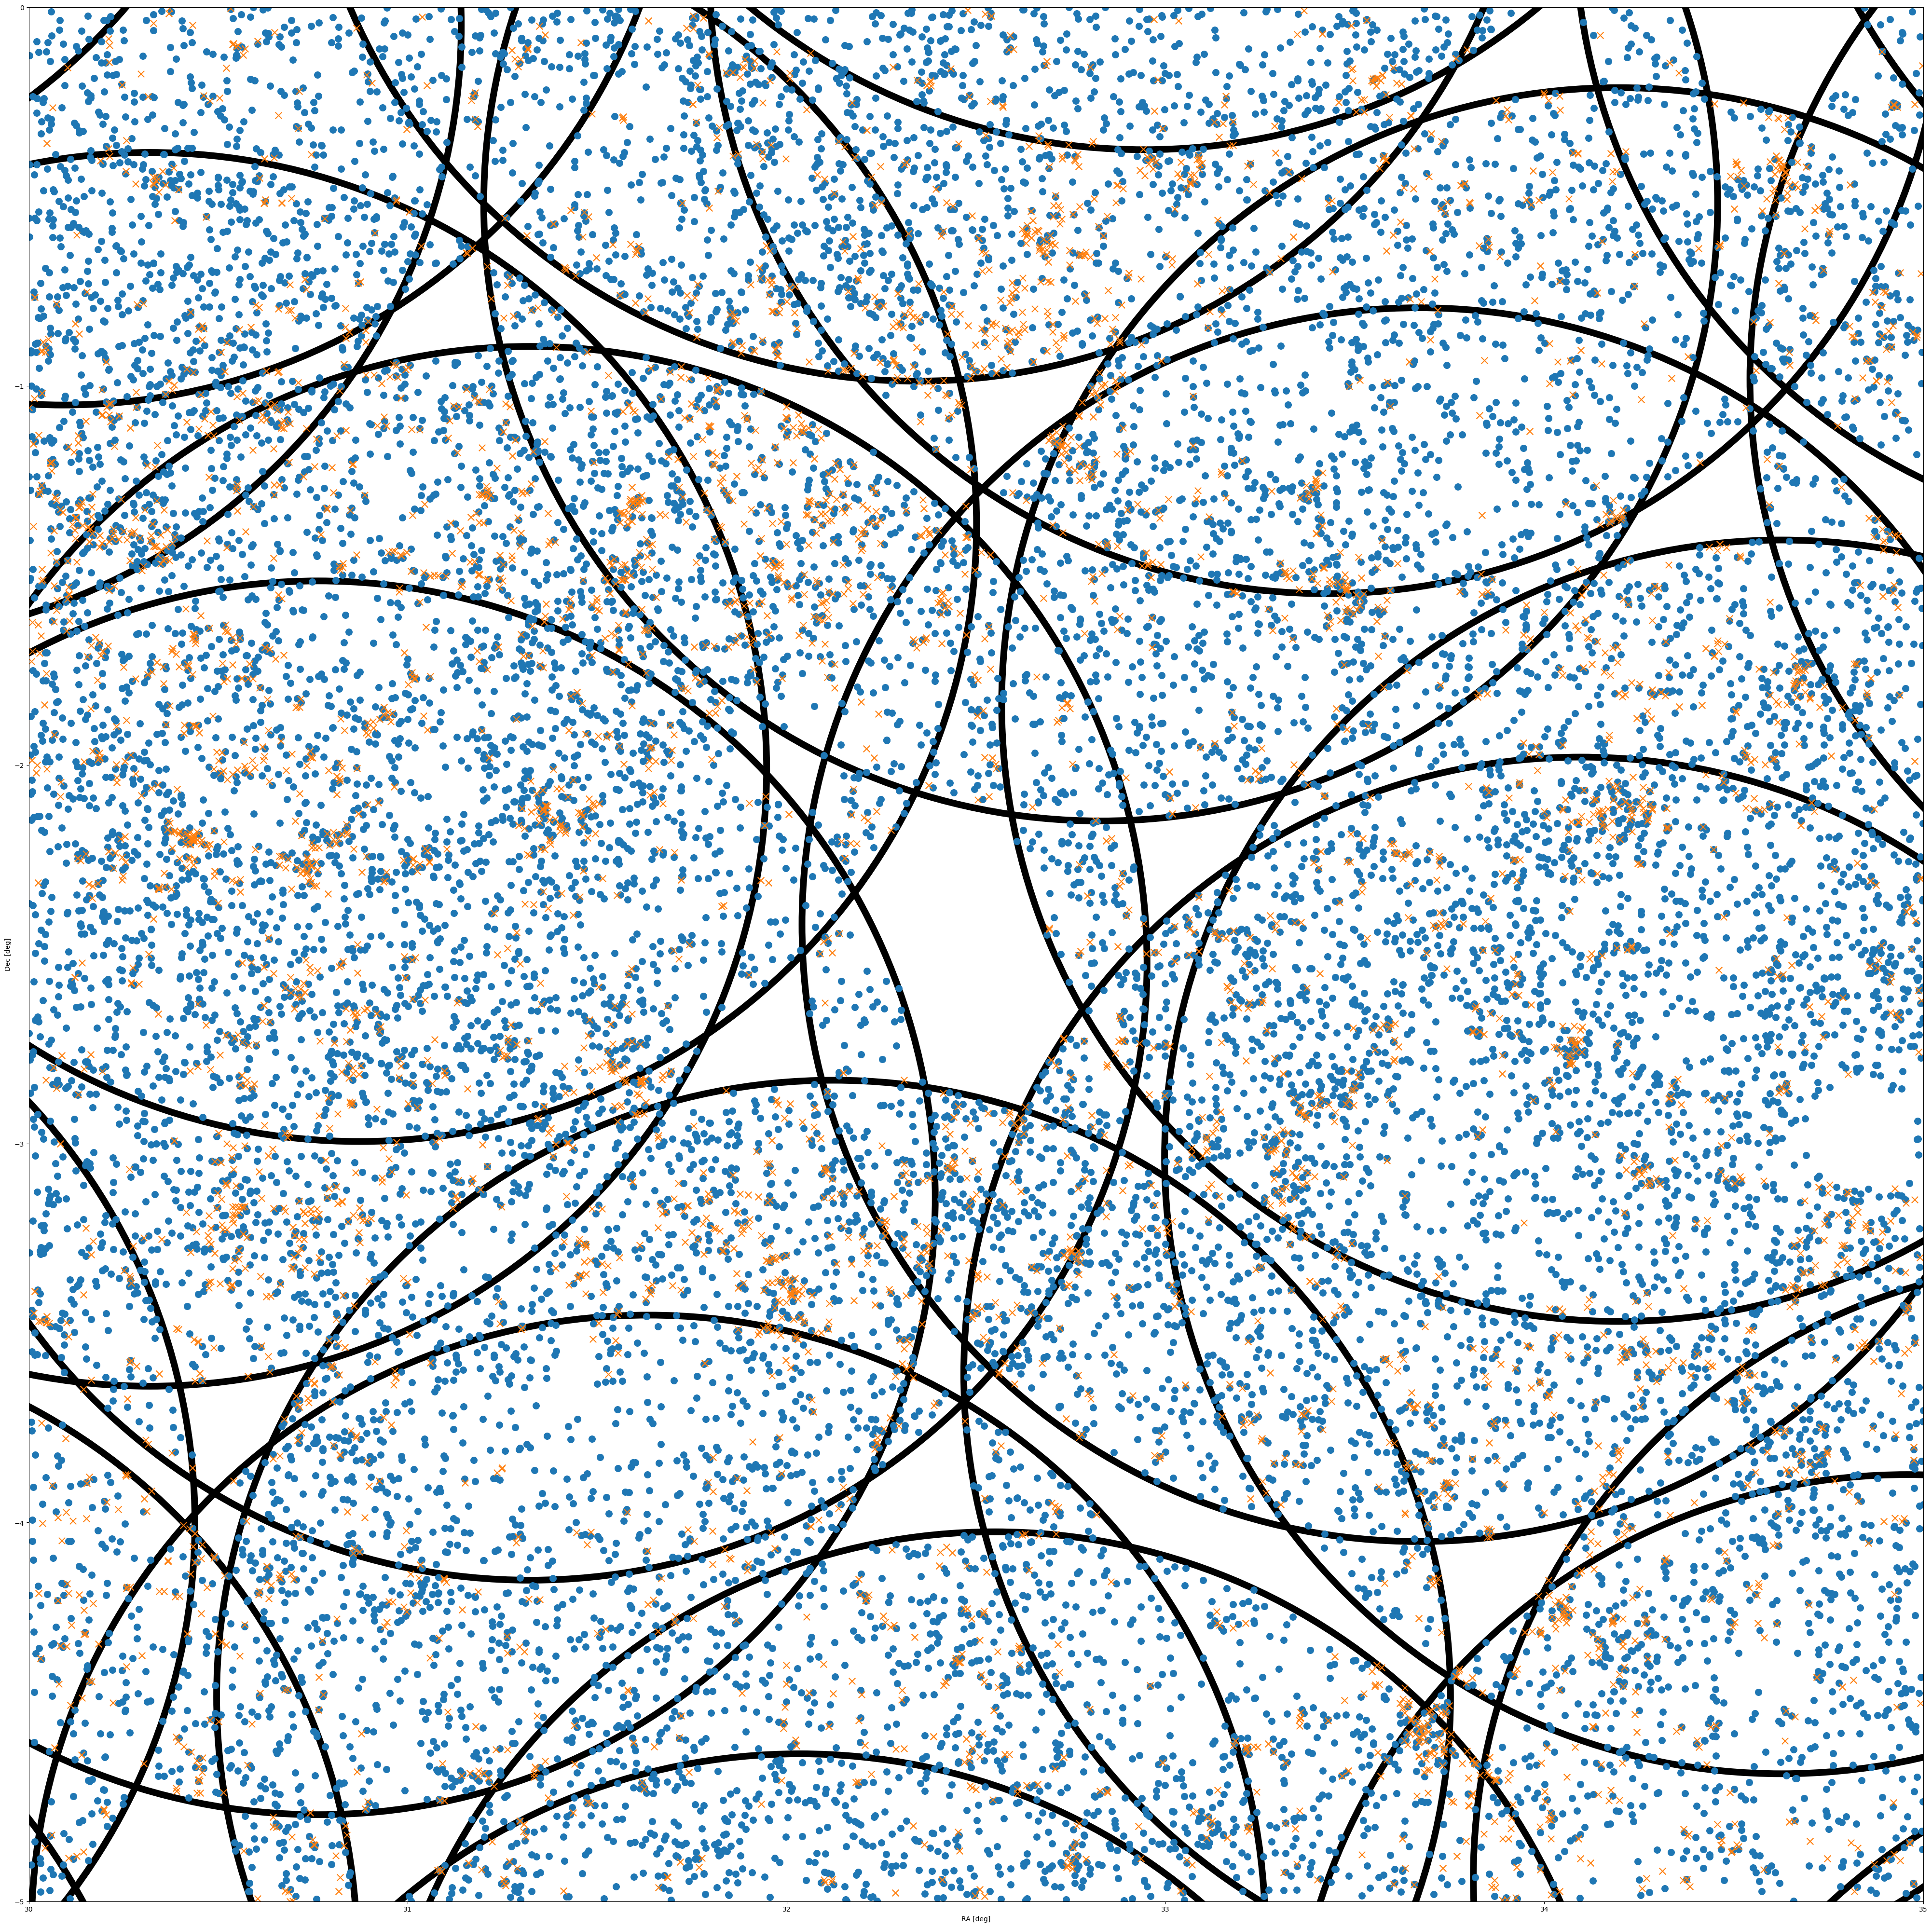

In [18]:
# Make maps
two_pass_filter = ntiles_mine >= 2 
three_pass_filter = ntiles_mine >= 3 
four_pass_filter = ntiles_mine >= 4 

ra2 = ra[two_pass_filter]
dec2 = dec[two_pass_filter]
tileids2 =  tileids[two_pass_filter]
unobserved2 = unobserved[two_pass_filter]

ra3 = ra[three_pass_filter]
dec3 = dec[three_pass_filter]
tileids3 =  tileids[three_pass_filter]
unobserved3 = unobserved[three_pass_filter]

ra4 = ra[four_pass_filter]
dec4 = dec[four_pass_filter]
tileids4 =  tileids[four_pass_filter]
unobserved4 = unobserved[four_pass_filter]

one_pass_df = pd.DataFrame({'RA': ra, 'Dec': dec, 'z_assigned_flag': unobserved, 'TILEID': tileids})
two_pass_df = pd.DataFrame({'RA': ra2, 'Dec': dec2, 'z_assigned_flag': unobserved2, 'TILEID': tileids2})
three_pass_df = pd.DataFrame({'RA': ra3, 'Dec': dec3, 'z_assigned_flag': unobserved3, 'TILEID': tileids3})
four_pass_df = pd.DataFrame({'RA': ra4, 'Dec': dec4, 'z_assigned_flag': unobserved4, 'TILEID': tileids4})

dataset1 = types.SimpleNamespace()
dataset1.all_data = one_pass_df
dataset2 = types.SimpleNamespace()
dataset2.all_data = two_pass_df
dataset3 = types.SimpleNamespace()
dataset3.all_data = three_pass_df
dataset4 = types.SimpleNamespace()
dataset4.all_data = four_pass_df

plot_positions(dataset3, tiles_df=tiles_BGS, DEG_LONG=5, split=True)

#fig=make_map(ra, dec)
#ra_4 = ra[four_pass_filter]
#dec_4 = dec[four_pass_filter]
#print(f"Number of 4-pass galaxies: {len(ra_4)}, number of 3-pass galaxies: {len(ra)}")
#fig=make_map(ra_4, dec_4, fig=fig, alpha=0.1)

## Color Analysis

Lesson from this analysis: the BGS data, workign with my 0.1^G-R with GAMA k-corrections, does not distribute a per logLgal bin G-R; the global 0.76 split seems to work for all bins.

In [ ]:
G = app_mag_to_abs_mag(app_mag_g, z_obs)
R = app_mag_to_abs_mag(app_mag_r, z_obs)

G_R = G - R

Gk = k_correct_bgs(G, z_obs, g_r_apparent, band='g')
Rk = k_correct_bgs(R, z_obs, g_r_apparent, band='r')

G_R_k = Gk - Rk

Gk_GAMA = k_correct_gama(G, z_obs, g_r_apparent, band='g')
Rk_GAMA = k_correct_gama(R, z_obs, g_r_apparent, band='r')

G_R_k_GAMA = Gk_GAMA - Rk_GAMA


In [ ]:
# Comparison of g-r computed a few ways
bins = np.linspace(0, 2.0, 200)

plt.figure()
#junk=plt.hist(g_r_apparent, bins=bins, label="g-r", histtype='step')
junk=plt.hist(sdss_g_r, bins=bins, label='From LSS Pipeline (JM?)', histtype='step', density=True)
#junk=plt.hist(G_R, bins=bins, label="G-R", histtype='step')
junk=plt.hist(G_R_k, bins=bins, label="0.1^(G-R) BGS poly", histtype='step', density=True)
junk=plt.hist(G_R_k_GAMA, bins=bins, label="0.1^(G-R) GAMA poly", histtype='step', density=True)
junk=plt.hist(G_R_JM1, bins=bins, label="0.1^(G-R) JM", histtype='step', density=True)
plt.xlabel("g-r")
plt.ylabel("Count")
plt.legend()
plt.xlim(0.2, 1.3)
plt.title("Comparison of g-r computed a few ways")
plt.tight_layout()
plt.ylim(0,3.5)

In [ ]:
# Can see global GLOBAL_RED_COLOR_CUT=0.76 here
junk=plt.hist(G_R_k, bins=300, alpha=0.5, label="0.1^(G-R) GAMA-style")
plt.legend()
plt.xlim(0.5, 1.0)

In [ ]:
from pyutils import *
print(BGS_LOGLGAL_BINS)
print(BINWISE_RED_COLOR_CUT)

In [ ]:
is_quiescent_BGS_gmr(np.array([5.8, 9.0, 14.5]), np.array([0.5, 0.9, 0.9]))

In [ ]:
# Get logLgal bins
log_L_gal = abs_mag_r_to_log_solar_L(Rk) 
logLgal_bin_idx = np.digitize(log_L_gal, BGS_LOGLGAL_BINS)
# 0 is less than the lowest, len(BGS_LOGLGAL_BINS) is greater than the highest entry in BGS_LOGLGAL_BINS

In [ ]:
print(np.min(log_L_gal))
print(np.max(log_L_gal))
print(np.min(logLgal_bin_idx))
print(np.max(logLgal_bin_idx))
plt.hist(log_L_gal, bins=BGS_LOGLGAL_BINS, align='mid')
#plt.yscale('log')

In [ ]:
# Make a plot of G_R_k in each logLgal bin
for i in range(0, len(BGS_LOGLGAL_BINS)+1):
    galaxy_idx_for_this_bin = logLgal_bin_idx == i

    plt.figure(dpi=80, figsize=(10, 6))
    junk=plt.hist(G_R_k[galaxy_idx_for_this_bin], bins=np.arange(0,1.3,0.02), label=f"0.1^(G-R) Bin {i}", align='mid')
    plt.legend()
    plt.xlim(0.4, 1.2)
    plt.xticks(np.arange(0.4, 1.2, 0.04))

In [ ]:
mag1 = abs_mag_sdss
mag2 = R

In [ ]:
# Compare Absolute Magnitudes
# Difference is how we k-correct I believe
bins = np.linspace(-25, -10, 100)
my_counts, my_bins, my_p = plt.hist(mag2, label="my abs_mag", bins=bins, alpha=0.5)
alex_counts, alex_bins, alex_p = plt.hist(mag1, label="ABSMAG_SDSS_R", bins=bins, alpha=0.5)
plt.xlabel("Absolute Mag")
plt.ylabel("Count")
plt.title("Compare Absolute Mags")
#plt.yscale('log')
plt.legend()

print(f"The peak is shifted from ABSMAG_SDSS_R {alex_bins[np.argmax(alex_counts)]:.1f} to my {my_bins[np.argmax(my_counts)]:.1f}")


In [ ]:
fig=make_map(ra, dec)

## Dn4000 Comparison (BGS, SDSS)

In [ ]:
sdss = pd.read_csv(SDSS_v1_DAT_FILE, delimiter=' ', names=('RA', 'Dec', 'z', 'logLgal', 'V_max', 'quiescent', 'chi'), index_col=False)
sdss_galprops = pd.read_csv("../data/sdss_galprops_v1.0.dat", delimiter=' ', names=('Mag_g', 'Mag_r', 'sigma_v', 'Dn4000', 'concentration', 'log_M_star'))
sdss = pd.merge(sdss, sdss_galprops, left_index=True, right_index=True)


In [ ]:
plt.hist(dn4000, bins=np.linspace(-0.5, 5.0, 100), alpha=0.6, label="BGS Y1")
plt.hist(sdss.Dn4000, bins=np.linspace(-0.5, 5.0, 100), alpha=0.8, label="SDSS")
plt.yscale('log')
plt.legend()
plt.xlabel('Dn4000')
plt.ylabel('Count')

In [ ]:
plt.hist(dn4000, bins=np.linspace(-0.5, 5.0, 100), alpha=0.6, label="BGS Y1")
plt.hist(sdss.Dn4000, bins=np.linspace(-0.5, 5.0, 100), alpha=0.8, label="SDSS")
plt.legend()
plt.xlabel('Dn4000')
plt.ylabel('Count')
plt.xlim(0.9,2.5)

In [ ]:
sdss_catalog = coord.SkyCoord(ra=sdss.RA.to_numpy()*u.degree, dec=sdss.Dec.to_numpy()*u.degree, frame='icrs')
BGS_catalog = coord.SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

neighbor_indexes, d2d, d3d = coord.match_coordinates_sky(BGS_catalog, sdss_catalog, storekdtree='sdss')
ang_distances = d2d.to(u.arcsec).value

match_found_filter = ang_distances < 3.0
bgs_matches = dn4000[match_found_filter]
sdss_indexes = neighbor_indexes[match_found_filter]
sdss_matches = sdss.iloc[sdss_indexes].Dn4000.to_numpy()

In [ ]:
print(f"{np.isclose(bgs_matches, sdss_matches, atol=0.05).sum() / len(bgs_matches)} of the matches are within 0.05 of each other.")
print(f"{np.isclose(bgs_matches, sdss_matches, atol=0.1).sum() / len(bgs_matches)} of the matches are within 0.1 of each other.")
print(f"{np.isclose(bgs_matches, sdss_matches, atol=0.2).sum() / len(bgs_matches)} of the matches are within 0.2 of each other.")
print(f"{np.isclose(bgs_matches, sdss_matches, atol=0.3).sum() / len(bgs_matches)} of the matches are within 0.3 of each other.")


In [ ]:
fig=make_map(ra, dec)
fig=make_map(sdss.RA.to_numpy(), sdss.Dec.to_numpy(), fig=fig, alpha=0.05)

In [ ]:
plt.scatter(sdss_matches, bgs_matches, s=1, alpha=.2)
plt.xlabel("SDSS Dn4000")
plt.ylabel("BGS Dn4000")
plt.xlim(1, 2.3)
plt.ylim(1, 2.3)

In [ ]:
df = pd.DataFrame({'SDSS_Dn4000': sdss_matches, 'BGS_Dn4000': bgs_matches})
df['diff_frac'] =  (df['BGS_Dn4000'] - df['SDSS_Dn4000']) / df['SDSS_Dn4000']
bins = np.linspace(-1, 5, 60)
labels = bins[0:len(bins)-1] 
df['dn4000_sdssbin'] = pd.cut(x = sdss_matches, bins = bins, labels = labels, include_lowest = True)

In [ ]:
plt.figure(dpi=80)
diff_mean = df.groupby('dn4000_sdssbin').diff_frac.mean()
diff_std= df.groupby('dn4000_sdssbin').diff_frac.std()

plt.errorbar(labels, diff_mean, yerr=diff_std)
plt.xlabel("SDSS Dn4000")
plt.ylabel("< (BGS-SDSS) / SDSS >")
plt.xlim(0.8, 2.4)
plt.ylim(-0.75, 0.75)
plt.draw()

## Dn4000 Lgal Bin Analysis

Run Color Analysis and Dn4000 Comparison first

In [ ]:
# Make a plot of Dn4000 in each logLgal bin
fig,axes=plt.subplots(dpi=80, figsize=(10, 3*len(BGS_LOGLGAL_BINS)//2), ncols=2, nrows=len(BGS_LOGLGAL_BINS)//2)
axes = np.ravel(axes)

for i in range(0, len(BGS_LOGLGAL_BINS)-1):
    galaxy_idx_for_this_bin = logLgal_bin_idx == i+1

    junk=axes[i].hist(dn4000[galaxy_idx_for_this_bin], bins=np.arange(1,2.2,0.02), label=f"Dn4000 for logLgal Bin {i+1}", align='mid')
    axes[i].legend()
    axes[i].set_xlim(1, 2.2)
    axes[i].set_xticks(np.arange(1, 2.2, 0.1))

    # draw a vertical line at get_SDSS_Dcrit(logLgal)
    axes[i].axvline(x=get_SDSS_Dcrit(BGS_LOGLGAL_BINS[i]), color='r', linestyle='-')

axes = np.reshape(axes, (2, len(BGS_LOGLGAL_BINS)//2))


# Randoms Analysis for Footprint

In [ ]:
rtable = Table.read(BGS_Y3_RAND_FILE, format='fits')
rtable.columns
rtable.keep_columns(['LOCATION', 'FIBER', 'TARGETID', 'RA', 'DEC', 'PRIORITY', 'TILEID', 'TILELOCID', 'NTILE', 'TILES'])

In [ ]:
r_dec = rtable['DEC'].astype("<f8")
r_ra = rtable['RA'].astype("<f8")
r_ntiles = rtable['NTILE'].astype("<i8")
r_tileid = rtable['TILEID'].astype("<i8")

# TODO TILEID is just one, TILES has them all... look at rtable['TILES'][135000] for example
randoms_df = pd.DataFrame({'RA': r_ra, 'Dec': r_dec, 'NTILE': r_ntiles, 'TILEID': r_tileid})

RANDOMS_DENSITY = 2500 # per square degree, Ashley Ross paper on LSS pipeline or elsewhere in docs

onepass_footprint = len(r_dec) / RANDOMS_DENSITY # in degrees squared
onepass_frac_area = onepass_footprint / DEGREES_ON_SPHERE

three_pass_filter = r_ntiles >= 3 # 3pass coverage
r_dec3 = r_dec[three_pass_filter]
r_ra3 = r_ra[three_pass_filter]

threepass_footprint = len(r_dec3) / RANDOMS_DENSITY # in degrees squared
threepass_frac_area = threepass_footprint / DEGREES_ON_SPHERE

# My estimation procedure, which we don't use
estimate = estimate_frac_area(r_ra, r_dec)
estimate3 = estimate_frac_area(r_ra3, r_dec3)

In [ ]:
print("INCORRECT RESULTS THAT USE NTILE, NOT NTILE_MINE")
print(f"BGS 1pass Footprint calculated from randoms is {onepass_footprint} square degrees or frac_area={onepass_frac_area}")
print(f"BGS 3pass Footprint calculated from randoms is {threepass_footprint} square degrees or frac_area={threepass_frac_area}")
#print(f"BGS 1pass Footprint estimated from my algorithm: frac_area={estimate}")
#print(f"BGS 3pass Footprint estimated from my algorithm: frac_area={estimate3}")

### Make map showing why we cannot use NTILE >= 3

In [ ]:
# Make maps
dataset1 = types.SimpleNamespace()
dataset1.all_data = randoms_df
dataset3_by_NTILE = types.SimpleNamespace()
dataset3_by_NTILE.all_data = randoms_df[randoms_df.NTILE >= 3]

tiles_BGS = read_tiles_file()

In [ ]:
# Plot the galaxy positions (randoms) and return the set of tile_id associated with them
plot_positions(dataset1, dataset3_by_NTILE, tiles_df=tiles_BGS, DEG_LONG=10, split=False)

### Make map with NTILE_MINE

Uses a NN lookup of the tiles for each 'galaxy'.

In [ ]:
NTILE_MIN = 5
ntiles_inside, nearest_tile_ids = find_tiles_for_galaxies(tiles_BGS, randoms_df, NTILE_MIN) # TODO should save for randoms...
randoms_df['NTILE_MINE'] = ntiles_inside
# Not sure if I really need the nearset tile IDs for anything


In [ ]:
pickle.dump(randoms_df, open(BIN_FOLDER + "randoms_df.p", "wb"))

In [ ]:
randoms_df = pickle.load(open(BIN_FOLDER + "randoms_df.p", "rb"))

In [ ]:
print(np.sum(ntiles_inside >= 3) / len(ntiles_inside))
print(np.sum(ntiles_inside >= 3))

In [ ]:
# Plot the galaxy positions (randoms) and return the set of tile_id associated with them
dataset1 = types.SimpleNamespace()
dataset1.all_data = randoms_df
dataset3 = types.SimpleNamespace()
dataset3.all_data = randoms_df[randoms_df.NTILE_MINE >= 3]

plot_positions(dataset1, dataset3, tiles_df=tiles_BGS, DEG_LONG=10, split=False)

In [ ]:
# Recalculate Footprint given this definition
onepass_footprint_mine = len(randoms_df.RA) / RANDOMS_DENSITY # in degrees squared
onepass_frac_area_mine = onepass_footprint_mine / DEGREES_ON_SPHERE
twopass_footprint_mine = len(randoms_df[randoms_df.NTILE_MINE >= 2].RA) / RANDOMS_DENSITY # in degrees squared
twopass_frac_area_mine = twopass_footprint_mine / DEGREES_ON_SPHERE
threepass_df = randoms_df[randoms_df.NTILE_MINE >= 3]
threepass_footprint_mine = len(threepass_df.RA) / RANDOMS_DENSITY # in degrees squared
threepass_frac_area_mine = threepass_footprint_mine / DEGREES_ON_SPHERE
fourpass_df = randoms_df[randoms_df.NTILE_MINE >= 4]
fourpass_footprint_mine = len(fourpass_df.RA) / RANDOMS_DENSITY # in degrees squared
fourpass_frac_area_mine = fourpass_footprint_mine / DEGREES_ON_SPHERE
print(f"BGS 1pass Footprint calculated from randoms is {onepass_footprint_mine} square degrees or frac_area={onepass_frac_area_mine}")
print(f"BGS 2pass Footprint calculated from randoms is {twopass_footprint_mine} square degrees or frac_area={twopass_frac_area_mine}")
print(f"BGS 3pass Footprint calculated from randoms is {threepass_footprint_mine} square degrees or frac_area={threepass_frac_area_mine}")
print(f"BGS 4pass Footprint calculated from randoms is {fourpass_footprint_mine} square degrees or frac_area={fourpass_frac_area_mine}")

# Ztiles Y3

In [ ]:
# I think this has no lost galaxies in it
hdul = fits.open(BGS_Y3_ZTILES, memmap=True)
print(hdul[1].columns)
data = hdul[1].data
targetid = data['TARGETID']
dec = data['TARGET_DEC'] 
ra = data['TARGET_RA']
redshift = data['Z']
spectype = data['SPECTYPE']
flux_r = data['FLUX_R']
flux_g = data['FLUX_G']
deltachi2 = data['DELTACHI2']  

df = pd.DataFrame({
    'SPECTYPE': spectype,
    'Dec': dec,
    'RA': ra,
    'z': redshift,
    'flux_r': flux_r,
    'flux_g': flux_g,
    'TARGETID': targetid,
    'DELTACHI2': deltachi2,
    })

hdul.close()

In [ ]:
np.sum(np.isnan(df.z))

In [ ]:
ntiles_inside, nearest_tile_ids = find_tiles_for_galaxies(tiles_BGS, df, 10)


# View Healpix Files

I don't know what these are.

In [ ]:
BGS_N = hp.read_map(BGS_FOLDER + 'BGS_BRIGHT_mapprops_healpix_nested_nside256_N.fits')
BGS_S = hp.read_map(BGS_FOLDER + 'BGS_BRIGHT_mapprops_healpix_nested_nside256_S.fits')

In [ ]:
hp.mollview(
    BGS_N,
    coord=["G", "E"],
    title="Histogram equalized Ecliptic",
    unit="Galaxies",
    norm="hist",
    min=0,
    max=1,
)
hp.graticule()

In [ ]:
hp.mollview(
    BGS_S,
    coord=["G", "E"],
    title="Histogram equalized Ecliptic",
    unit="Galaxies",
    norm="hist",
    min=0,
    max=1,
)
hp.graticule()